In [9]:
import pandas as pd
import sys
import os
import math
import pandas as pd
from scipy.stats import ttest_ind
import scipy.stats as sp
import plotly.express as px
import plotly.io as pio
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

sys.path.append('../src/')
from constants import SAMPLES, matching_cores_2024, CB_COLORS_5

wd = os.getcwd()
print (f'working directory: {wd}')

def log2_fold_change(a, b):
    """
    Calculate the log2 fold change between two expression values a and b.
    
    Parameters:
    a (float): Expression value in condition A (control or reference)
    b (float): Expression value in condition B (treatment or experimental)
    
    Returns:
    float: The log2 fold change
    """
    if a == 0:
        raise ValueError("Expression value 'a' should not be zero to avoid division by zero.")
    fold_change = b / a
    log2_fc = math.log2(fold_change)
    return log2_fc


gene_list_dict = {
    'co':['CD274','PDCD1', 'PDCD1LG2', 'CCL5', 'CXCL12', 'CD68', 'CTLA4'],
    'not_co':['ADIPOQ', 'KIT'],
}


if not os.path.exists(f'{wd}/figures/protein_validation'):
    os.makedirs(f'{wd}/figures/protein_validation')

pd_l1_high_cores = [
    1.0, 2.0, 3.0, 6.0, 7.0, 8.0, 37.0, 39.0, 41.0, 42.0,
    43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0,
    52.0, 55.0, 56.0, 57.0, 58.0, 60.0, 62.0, 64.0, 66.0,
    69.0, 70.0, 71.0, 79.0, 82.0, 83.0, 84.0, 85.0, 91.0,
    92.0, 93.0, 94.0, 95.0, 96.0, 101.0, 102.0, 111.0, 112.0,
    113.0, 114.0, 115.0, 116.0, 117.0, 118.0, 119.0, 120.0,
    121.0, 122.0, 127.0, 128.0, 129.0, 133.0, 134.0, 138.0,
    139.0, 140.0, 144.0, 148.0, 149.0, 150.0, 151.0, 152.0,
    153.0, 155.0, 156.0, 159.0, 160.0, 161.0, 164.0, 165.0,
    168.0, 169.0, 170.0]

working directory: /Users/whuan/dev/ist_benchmarking


In [3]:

df_core = pd.read_csv(f'{wd}/data/Sample_Info_HTMA_TMA - Sheet1.csv')[['core', 'tissue_type', 'patient_number', 'PD-L1_status']]
df_core['unique_patient_number'] = df_core.apply(lambda row: f"{row['tissue_type']}_{row['patient_number']}_{row['PD-L1_status']}", axis=1)

df_all = pd.DataFrame()

gene_list = ['CD274']
for sample in SAMPLES:
    if '2024' in sample and 'htma' in sample:
        print (sample)
        df = pd.read_csv(f'{wd}/data/gene_level_csv/gene_level_csv_{sample}.csv', engine='pyarrow')
        df_selected = df.loc[df["gene"].isin(gene_list)]
        df_join = pd.merge(df_selected, df_core, on=['core','tissue_type'], how='left')
        df_join['sample'] = sample
        df_join['core'] = df_join['core'].astype('int')
        df_join = df_join.loc[df_join['core'].isin(matching_cores_2024)]
        df_all = pd.concat([df_all, df_join])

df_all['platform'] = df_all['sample'].apply(lambda x: x.split('_')[-3].upper())
df_all['platform'] = df_all['platform'].replace({'XENIUM':'Xenium','MERSCOPE':'MERSCOPE','COSMX':'CosMx'})
df_all = df_all[['count', 'PD-L1_status', 'platform']]

2024_xenium_breast_htma
2024_merscope_breast_htma
2024_cosmx_multitissue_htma


In [4]:
df = df_all[['count', 'PD-L1_status', 'platform']]

# Calculate the mean count and the number of entries (n) for each sample and PD-L1 status
df_stats = (
    df
    .groupby(by=['platform', 'PD-L1_status'])
    .agg(Num_of_Cores=('count', 'size'), Average_CD274_Expression=('count', 'mean'))
    .reset_index()
)

# Display the resulting DataFrame
display(df_stats)


,platform,PD-L1_status,Num_of_Cores,Average_CD274_Expression
0,CosMx,high,38,199.921053
1,CosMx,low,27,183.518519
2,MERSCOPE,high,32,21.281250
3,MERSCOPE,low,25,28.960000
4,Xenium,high,38,357.421053
5,Xenium,low,27,284.111111


In [5]:

# Remove rows with NaN in PD-L1_status to focus only on 'high' and 'low'
df_filtered = df.dropna(subset=['PD-L1_status'])

# Define the function to calculate p-values for each sample
def calculate_p_values(df):
    results = []
    for platform in df['platform'].unique():
        df_platform = df[df['platform'] == platform]
        
        # Ensure there are 'high' and 'low' counts to compare
        if 'high' in df_platform['PD-L1_status'].values and 'low' in df_platform['PD-L1_status'].values:
            high_counts = df_platform[df_platform['PD-L1_status'] == 'high']['count']
            low_counts = df_platform[df_platform['PD-L1_status'] == 'low']['count']
            
            # Perform t-test
            t_stat, p_val = ttest_ind(high_counts, low_counts, equal_var=False)
            
            # Determine significance based on p-value threshold (0.05)
            significant = p_val < 0.05
            
            # Append result
            results.append({
                'platform': platform,
                'p_value': p_val,
                'significant': significant
            })
    
    return pd.DataFrame(results)

# Calculate p-values and significance for each sample
df_results = calculate_p_values(df_filtered)

# Display the results
print("Results DataFrame:")
display(df_results)


Results DataFrame:


,platform,p_value,significant
0,Xenium,0.508350,False
1,MERSCOPE,0.413921,False
2,CosMx,0.732083,False


# CD274 expression by PD-L1 status


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


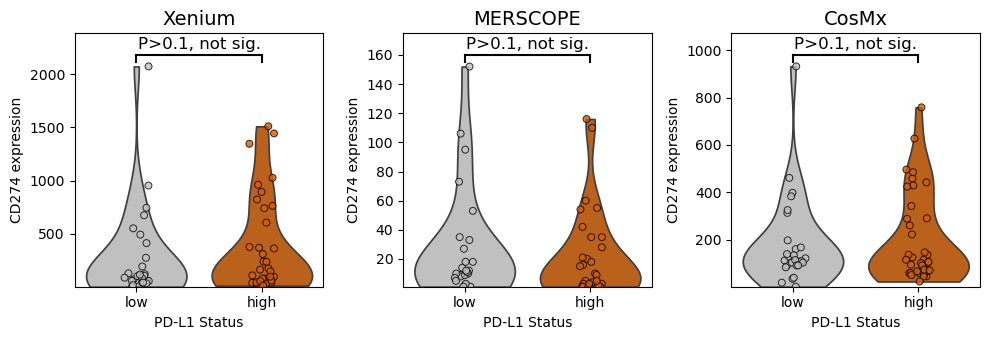

In [7]:

# Example platforms in df_all: ['Xenium','MERSCOPE','CosMx']
platforms = df_all['platform'].unique()

# Create a 1 row x N columns figure (N = number of platforms)
fig, axes = plt.subplots(1, len(platforms), figsize=(10, 3.5), sharey=False)

# Define a color palette mapping for PD-L1_status
palette = {'low': CB_COLORS_5['grey'], 'high': CB_COLORS_5['red']}

for i, platform in enumerate(platforms):
    ax = axes[i]
    subset = df_all[df_all['platform'] == platform]

    # Violin plot
    sns.violinplot(
        x='PD-L1_status',
        y='count',
        data=subset,
        palette=palette,
        cut=0,
        scale='width',
        inner=None,
        order=['low', 'high'],
        ax=ax
    )

    # Strip plot overlaid
    sns.stripplot(
        x='PD-L1_status',
        y='count',
        data=subset,
        hue='PD-L1_status',
        palette=palette,
        dodge=False,
        order=['low', 'high'],
        edgecolor='black',
        linewidth=0.7,
        alpha=0.8,
        ax=ax
    )

    # Remove legend in each subplot
    ax.legend_.remove()

    # Title
    ax.set_title(platform, fontsize=14)

    # Get min/max for this platform
    y_min = subset['count'].min()
    y_max = subset['count'].max()

    # Increase the upper limit so we have space for the bracket/annotation
    ax.set_ylim(y_min * 0.95, y_max * 1.15)

    # Position the bracket slightly below the new top
    bracket_y = y_max * 1.05     # bracket line
    bracket_height = y_max * 0.03  # bracket vertical size

    # Draw bracket: horizontal line from x=0 to x=1
    ax.plot([0, 1], [bracket_y, bracket_y], lw=1.5, color='black')
    # Left vertical
    ax.plot([0, 0], [bracket_y, bracket_y - bracket_height], lw=1.5, color='black')
    # Right vertical
    ax.plot([1, 1], [bracket_y, bracket_y - bracket_height], lw=1.5, color='black')

    # Annotation text above bracket
    ax.text(
        0.5, 
        bracket_y + (bracket_height * 0.5),
        'P>0.1, not sig.',
        ha='center',
        va='bottom',
        fontsize=12
    )
    ax.set_xlabel("PD-L1 Status")
    ax.set_ylabel("CD274 expression")

plt.tight_layout()

plt.savefig(f'{wd}/figures/response_letter/gene_expression_by_pd_l1_status_by_platform.png', 
            dpi=250, transparent=True)
plt.savefig(f'{wd}/figures/response_letter/gene_expression_by_pd_l1_status_by_platform.eps', 
            dpi=250, transparent=True)
plt.show()


# Protein expression vs. iST expression

In [8]:
df_core = pd.read_csv(f'{wd}/data/Sample_Info_HTMA_TMA - Sheet1.csv')[['core', 'tissue_type', 'patient_number', 'PD-L1_status']]
df_core['unique_patient_number'] = df_core.apply(lambda row: f"{row['tissue_type']}_{row['patient_number']}_{row['PD-L1_status']}", axis=1)

def get_protein_expression(core, tech):

    file_dict = {
        'codex':f'/Users/whuan/dev/OPP/codex_pipeline/2022_tma_1/quantification/single_cell_quantification_whole-cell_{core}_1230.csv',
        'cycif':f'/Users/whuan/dev/OPP/codex_pipeline/cycif_tma_010/quantification/single_cell_quantification_whole-cell_{core}_600.csv',
        'hmif':f'/Users/whuan/dev/OPP/codex_pipeline/tma_mac/quantification/single_cell_quantification_whole-cell_{core}_760.csv',
    }

    df = pd.read_csv(file_dict[tech], engine='pyarrow')
    # protein_expression = df['PD-L1'].mean()
    protein_expression = df['PD-L1'].quantile(0.75)
    return protein_expression


gene = 'CD274'

df_p_all = pd.DataFrame()
for sample in [
    '2024_xenium_breast_htma',
    '2024_merscope_breast_htma',
    '2024_cosmx_multitissue_htma',
    ]:
    print (sample)
    df = pd.read_csv(f'{wd}/data/gene_level_csv/gene_level_csv_{sample}.csv', engine='pyarrow')
    df_selected = df.loc[df["gene"]==gene]
    df_join = pd.merge(df_selected, df_core, on=['core','tissue_type'], how='left')
    df_join['sample'] = sample
    df_join['core'] = df_join['core'].astype('int')
    df_join = df_join.loc[df_join['core'].isin(matching_cores_2024)]
    df_join = df_join.loc[~df_join['core'].isin([x for x in range(100,111)]+[42,83,97,113,114,115,116,117,118,120])]
    df_join['platform'] = df_join['sample'].apply(lambda x: x.split('_')[-3].upper())
    df_join['platform'] = df_join['platform'].replace({'XENIUM':'Xenium','MERSCOPE':'MERSCOPE','COSMX':'CosMx'})
    for tech in ['codex','cycif','hmif']:
        df_join[f'{tech}_expression'] = df_join.apply(lambda row: get_protein_expression(row['core'], tech), axis=1)
    df_join = df_join.loc[df_join['PD-L1_status'].isin(['high','low'])]
    df_p_all = pd.concat([df_p_all, df_join])


# Melt the DataFrame
df_melted = df_p_all.melt(
    id_vars=['core', 'gene', 'tissue_type', 'count', 'code_type', 'patient_number', 'PD-L1_status', 'unique_patient_number', 'sample', 'platform'],
    value_vars=['codex_expression', 'cycif_expression', 'hmif_expression'],
    var_name='protein_platform', 
    value_name='protein_expression'
)

# Map platform column to remove '_expression' suffix
df_melted['protein_platform'] = df_melted['protein_platform'].str.replace('_expression', '').str.upper()
df_melted['protein_platform'] = df_melted['protein_platform'].apply(lambda x: {
    'CODEX':'PhenoCycler',
    'CYCIF':'CyCIF',
    'HMIF':'PhenoImager',
}[x])

# Display the resulting DataFrame
display(df_melted.head())

2024_xenium_breast_htma
2024_merscope_breast_htma
2024_cosmx_multitissue_htma


,core,gene,tissue_type,count,code_type,patient_number,PD-L1_status,unique_patient_number,sample,platform,protein_platform,protein_expression
0,125,CD274,NSCLC,57,gene,4.0,low,NSCLC_4.0_low,2024_xenium_breast_htma,Xenium,PhenoCycler,15.272572
1,126,CD274,NSCLC,121,gene,4.0,low,NSCLC_4.0_low,2024_xenium_breast_htma,Xenium,PhenoCycler,13.621205
2,127,CD274,NSCLC,50,gene,4.0,high,NSCLC_4.0_high,2024_xenium_breast_htma,Xenium,PhenoCycler,25.605011
3,128,CD274,NSCLC,40,gene,4.0,high,NSCLC_4.0_high,2024_xenium_breast_htma,Xenium,PhenoCycler,24.229490
4,129,CD274,NSCLC,377,gene,5.0,high,NSCLC_5.0_high,2024_xenium_breast_htma,Xenium,PhenoCycler,38.055491


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


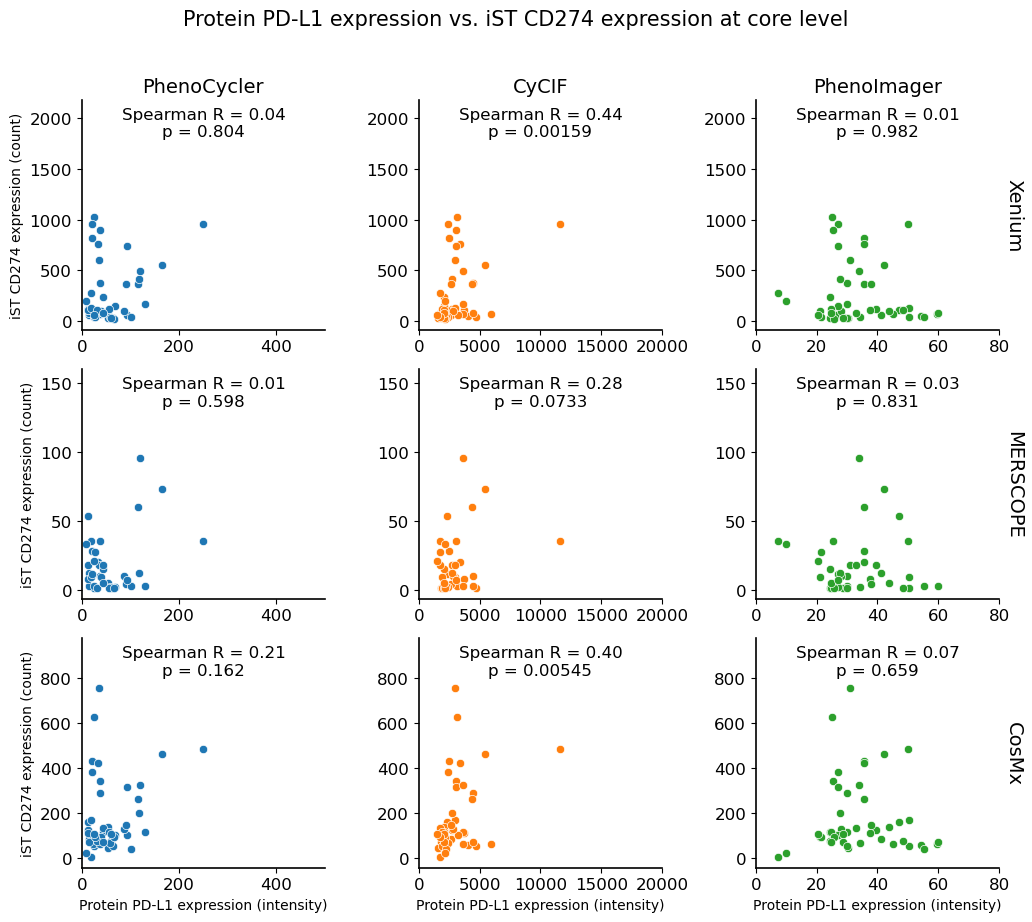

In [10]:

# 1) Create a FacetGrid
g = sns.FacetGrid(
    data=df_melted,
    row='platform',
    col='protein_platform',
    hue='protein_platform',
    height=3,
    aspect=1,
    margin_titles=True,
    sharex=False,
    sharey=False
)

# 2) Map a scatterplot onto each facet
g.map(
    sns.scatterplot,
    'protein_expression',  # x
    'count'                # y
)

# 3) Adjust x-range for each column, if desired
col_levels = df_melted['protein_platform'].unique()
for (row_val, col_val), ax in g.axes_dict.items():
    if col_val == col_levels[0]:
        ax.set_xlim(0, 500)
    elif col_val == col_levels[1]:
        ax.set_xlim(0, 20000)
    elif col_val == col_levels[2]:
        ax.set_xlim(0, 80)

# 4) Label axes and set fonts
g.set_axis_labels("Protein PD-L1 expression (intensity)", "iST CD274 expression (count)")
g.set_titles(row_template="{row_name}", col_template="{col_name}", size=14, color="black")

# 5) Customize spines, tick sizes, etc.
for ax in g.axes.flat:
    ax.spines['bottom'].set_linewidth(1.2)
    ax.spines['bottom'].set_color('black')
    ax.spines['left'].set_linewidth(1.2)
    ax.spines['left'].set_color('black')
    ax.tick_params(axis='both', which='major', labelsize=12, color='black')

# 6) OPTIONAL: Remove legend if you don't need it
g.add_legend()
g._legend.remove()

# 7) Calculate Spearman R for each facet and annotate
for (row_val, col_val), ax in g.axes_dict.items():
    # Subset data for just this facet
    subset = df_melted[
        (df_melted['platform'] == row_val) & 
        (df_melted['protein_platform'] == col_val)
    ]
    # Compute Spearman correlation
    if not subset.empty:
        r, p = sp.stats.spearmanr(subset['protein_expression'], subset['count'])
        if r < 0.01:
            r = 0.01
        
        # Format p-value for nicer text
        if p < 0.0001:
            p_text = "<0.0001"
        else:
            p_text = f"{p:.3g}"

        # Annotate on the axes
        ax.text(
            0.5, 0.9,          # position in Axes coords (0=left/bottom, 1=right/top)
            f"Spearman R = {r:.2f}\np = {p_text}",
            ha='center',
            va='center',
            transform=ax.transAxes,
            color='black',
            fontsize=12,
            bbox=dict(boxstyle='round,pad=0.3', fc='white', ec='none', alpha=0.7)
        )

# 8) Overall figure title
g.fig.suptitle(
    "Protein PD-L1 expression vs. iST CD274 expression at core level",
    y=1.02,  # move the title slightly above the grid
    x=0.5,
    ha="center",
    fontsize=15,
    color="black"
)

plt.tight_layout()
plt.savefig(f'{wd}/figures/response_letter/protein_vs_ist.png', 
            dpi=250, transparent=True)
plt.savefig(f'{wd}/figures/response_letter/protein_vs_ist.eps', 
            dpi=250, transparent=True)
plt.show()


## Plot using plotly (Depreciated)

In [12]:
width=800
height=800
fontsize = 15
fig = px.scatter(df_melted, x=f"protein_expression", 
                y="count",
                color="protein_platform", 
                facet_col="protein_platform",
                facet_row="platform",
                width=width, height=height)

fig.update_xaxes(
    matches=None,
    title_text=f'',
    title_font=dict(size=fontsize),
    showline=True,
    linewidth=1,
    linecolor='black',
)

fig.update_yaxes(
    matches=None,
    title_text=f'',
    title_font=dict(size=fontsize),
    showline=True,
    linewidth=1,
    linecolor='black',
)

fig.update_xaxes(col=1, range=[0, 500])
fig.update_xaxes(col=2, range=[0, 20000])
fig.update_xaxes(col=3, range=[0, 80])


# Customize legend and layout
fig.update_layout(
    title_text=f'Protein PD-L1 expression vs. iST {gene} expression at core level',
    legend_title_text="",
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1,
        xanchor="center",
        x=0.5
    ),
    font=dict(size=fontsize, color='black'),
    showlegend=True,
)

for annotation in fig.layout.annotations:
    for platform in df_melted.platform.unique():
        if annotation.text == f'platform={platform}':
            annotation.text = platform
            annotation.font.size = fontsize
            annotation.font.color = 'black'  # Set the annotation text color to black
            annotation.x = 0.98
            annotation.textangle = 90

    for protein_platform in df_melted.protein_platform.unique():
        if annotation.text == f'protein_platform={protein_platform}':
            annotation.text = protein_platform
            annotation.font.size = fontsize
            annotation.font.color = 'black'  # Set the annotation text color to black
            annotation.y = -0.06
            annotation.textangle = 0

fig.show()

pio.write_image(fig, f'{wd}/figures/protein_validation/scatter_plot.png',scale=4, width=width, height=height)
pio.write_image(fig, f'{wd}/figures/protein_validation/scatter_plot.eps',scale=4, width=width, height=height)